# Analyze Tweets

In [2]:
# Twitter data analysis task starter.
import html
import json
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# First collect the data in json-file; specify file name here (adjust the number as queried)
##fjson = 'raw_tweet_data_200.json'
fjson = 'raw_tweet_data_10000.json'

In [4]:
# read json file with tweets data
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

10000

In [5]:
# tweet data record example: as documented for the Twitter API
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet
data[0]

{'id': '1551995229548396546',
 'public_metrics': {'retweet_count': 0,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'author_id': '317717924',
 'text': 'Gila, Shang-Chi and The Legend of The Ten Rings sebagus itu yaaa.\nOne of the best Marvel movies 💯',
 'created_at': '2022-07-26T18:17:52.000Z'}

In [6]:
# create pandas dataframe from tweet text content
# https://stackoverflow.com/a/43175477
df_tweets = pd.DataFrame([t['text'] for t in data], columns=['text'])
df_tweets

,text
0,"Gila, Shang-Chi and The Legend of The Ten Ring..."
1,@cevangelista413 Love how this can apply to tw...
2,She's a 10 but she hasn't watched a single Mar...
3,RT @Mohammed_Aigoin: Nous sommes le 9 Novembre...
4,"RT @THR: Destin Daniel Cretton, who helmed las..."
...,...
9995,RT @mcwm: there have now been three Marvel mov...
9996,@marvel_updat3s Oh
9997,Acabei de ver vídeo falando: A MARVEL ESTÁ FAL...
9998,RT @MarvelDailyArt: In an amazing feat of timi...


In [7]:
# add selected columns from tweet data fields
df_tweets['retweets'] = [t['public_metrics']['retweet_count'] for t in data]
df_tweets['favorites'] = [t['public_metrics']['like_count'] for t in data]
df_tweets['user'] = [t['author_id'] for t in data]
df_tweets

,text,retweets,favorites,user
0,"Gila, Shang-Chi and The Legend of The Ten Ring...",0,0,317717924
1,@cevangelista413 Love how this can apply to tw...,0,0,982397923542609927
2,She's a 10 but she hasn't watched a single Mar...,0,0,134143613
3,RT @Mohammed_Aigoin: Nous sommes le 9 Novembre...,354,0,911679852247441408
4,"RT @THR: Destin Daniel Cretton, who helmed las...",142,0,1499955577598128128
...,...,...,...,...
9995,RT @mcwm: there have now been three Marvel mov...,7521,0,622375481
9996,@marvel_updat3s Oh,0,0,1512921615025446912
9997,Acabei de ver vídeo falando: A MARVEL ESTÁ FAL...,3,28,1305990696277598208
9998,RT @MarvelDailyArt: In an amazing feat of timi...,6,0,1900953302


In [8]:
# text cleaning function: see prior class modules
stop_words = set(stopwords.words('english'))

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [9]:
# add clean text column
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_tweets['text_clean'] = df_tweets['text'].apply(text_cleanup)
df_tweets

,text,retweets,favorites,user,text_clean
0,"Gila, Shang-Chi and The Legend of The Ten Ring...",0,0,317717924,gila legend ten rings sebagus itu yaaa one bes...
1,@cevangelista413 Love how this can apply to tw...,0,0,982397923542609927,cevangelista413 love apply two different marve...
2,She's a 10 but she hasn't watched a single Mar...,0,0,134143613,10 watched single marvel movie
3,RT @Mohammed_Aigoin: Nous sommes le 9 Novembre...,354,0,911679852247441408,rt nous sommes le 9 novembre en france vous te...
4,"RT @THR: Destin Daniel Cretton, who helmed las...",142,0,1499955577598128128,rt thr destin daniel cretton helmed last years...
...,...,...,...,...,...
9995,RT @mcwm: there have now been three Marvel mov...,7521,0,622375481,rt mcwm three marvel movies taken place since ...
9996,@marvel_updat3s Oh,0,0,1512921615025446912,oh
9997,Acabei de ver vídeo falando: A MARVEL ESTÁ FAL...,3,28,1305990696277598208,acabei de ver vdeo falando marvel est falindo ...
9998,RT @MarvelDailyArt: In an amazing feat of timi...,6,0,1900953302,rt marveldailyart amazing feat timing avengers...


In [10]:
# sentiment analysis
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_tweets['polarity'] = df_tweets['text_clean'].apply(sentim_polarity)
df_tweets['subjectivity'] = df_tweets['text_clean'].apply(sentim_subject)
df_tweets

,text,retweets,favorites,user,text_clean,polarity,subjectivity
0,"Gila, Shang-Chi and The Legend of The Ten Ring...",0,0,317717924,gila legend ten rings sebagus itu yaaa one bes...,0.500000,0.150000
1,@cevangelista413 Love how this can apply to tw...,0,0,982397923542609927,cevangelista413 love apply two different marve...,0.250000,0.600000
2,She's a 10 but she hasn't watched a single Mar...,0,0,134143613,10 watched single marvel movie,-0.071429,0.214286
3,RT @Mohammed_Aigoin: Nous sommes le 9 Novembre...,354,0,911679852247441408,rt nous sommes le 9 novembre en france vous te...,0.000000,0.000000
4,"RT @THR: Destin Daniel Cretton, who helmed las...",142,0,1499955577598128128,rt thr destin daniel cretton helmed last years...,0.033333,0.155556
...,...,...,...,...,...,...,...
9995,RT @mcwm: there have now been three Marvel mov...,7521,0,622375481,rt mcwm three marvel movies taken place since ...,0.000000,0.000000
9996,@marvel_updat3s Oh,0,0,1512921615025446912,oh,0.000000,0.000000
9997,Acabei de ver vídeo falando: A MARVEL ESTÁ FAL...,3,28,1305990696277598208,acabei de ver vdeo falando marvel est falindo ...,0.000000,0.000000
9998,RT @MarvelDailyArt: In an amazing feat of timi...,6,0,1900953302,rt marveldailyart amazing feat timing avengers...,0.600000,0.900000


In [12]:
# define the list of brands to analyze, consistent with the search topic
#  for which the tweets were collected
brands = ['secret invasion', 'quantumania', 'guardians', 'loki', 'secret wars', 'daredevil', 'avengers']

In [13]:
# start a brand comparison dataframe
df_brands = pd.DataFrame(brands, columns=['brand'])
df_brands

,brand
0,secret invasion
1,quantumania
2,guardians
3,loki
4,secret wars
5,daredevil
6,avengers


In [14]:
# example: tweet subset mentioning a given brand
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html
df_tweets[df_tweets['text_clean'].str.contains("secret invasion")]

,text,retweets,favorites,user,text_clean,polarity,subjectivity
918,RT @DiscussingFill: I just realized that Marve...,1,0,946489395212931072,rt discussingfill realized marvel supposed rel...,-0.003409,0.430303
3934,I just realized that Marvel was supposed to re...,1,11,1447564911538843652,realized marvel supposed release new secret in...,-0.003409,0.430303
4485,RT @MarvelStudios: Just announced in Hall H: \...,23397,0,1129446962640629761,rt marvelstudios announced hall h marvel studi...,-0.012500,0.725000
7020,RT @bakiniz: MARVEL | Dizilerin yayın zamanı a...,6,0,80270401,rt bakiniz marvel dizilerin yayn zaman akland ...,-0.400000,0.700000
7043,RT @MarvelStudios: Marvel Studios’ “Secret Inv...,1612,0,1172501431015759873,rt marvelstudios marvel studios secret invasio...,-0.400000,0.700000
7543,RT @Abber_naffy: With Secret Invasion coming u...,3,0,1055538815375413249,rt secret invasion coming disneyplusuk think g...,-0.250000,0.650000
9442,RT @MarvelStudios: Just announced in Hall H: \...,23397,0,398572223,rt marvelstudios announced hall h marvel studi...,-0.012500,0.725000


In [15]:
# function to compute average sentiment of tweets mentioning a given brand
def brand_sentiment(b):
    return df_tweets[df_tweets['text_clean'].str.contains(b)]['polarity'].mean()

# Average tweet sentiment for those brands.

In [16]:
# brand sentiment comparison
df_brands['average_sentiment'] = df_brands['brand'].apply(brand_sentiment)
df_brands

,brand,average_sentiment
0,secret invasion,-0.154545
1,quantumania,0.006481
2,guardians,0.056891
3,loki,0.106708
4,secret wars,-0.199991
5,daredevil,0.252004
6,avengers,0.022289


In [17]:
# highest sentiment tweets
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
df_tweets.sort_values(by='polarity', ascending=False).head(10)

,text,retweets,favorites,user,text_clean,polarity,subjectivity
1537,"Hulk &amp; She-Hulk Rework Details, Dev Notes ...",0,0,1285274273884581898,hulk rework details dev notes gamma team best ...,1.0,0.3
8017,RT @holywoodhandle: During #Marvel panel at #S...,59,0,828346881424097280,rt holywoodhandle marvel panel sdcc also menti...,1.0,0.3
846,RT @holywoodhandle: During #Marvel panel at #S...,59,0,1078301929,rt holywoodhandle marvel panel sdcc also menti...,1.0,0.3
1560,CHRIS CLAREMONT AND SALVADOR LARROCA RETURN TO...,0,0,16187124,chris claremont salvador larroca return legend...,1.0,1.0
8741,RT @spideyscastle: moon knight 🤝 the punisher ...,5,0,1477722247,rt spideyscastle moon knight punisher daredevi...,1.0,0.3
3911,@AMN_SNK @SenorRacha @LuisN_94 @arifjoe71 @bdt...,0,0,1137871444338249728,senorracha arifjoe71 bdtwho dantecien th3wobot...,1.0,1.0
3998,@KarmKing001 Best cinematography in any marvel...,0,0,1497292872575557642,karmking001 best cinematography marvel movie,1.0,0.3
8323,best thing about the Marvel vs Capcom games is...,4,13,1291087748091146242,best thing marvel vs capcom games gave marvel ...,1.0,0.3
8282,HAHAHAHAH THIS IS THE BEST https://t.co/Hg6IYG...,0,0,2953096378,hahahahah best,1.0,0.3
1937,RT @ArachnidArt: best thing about the Marvel v...,4,0,716509447682596864,rt arachnidart best thing marvel vs capcom gam...,1.0,0.3


In [29]:
# lowest sentiment tweets
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
df_tweets.sort_values(by='polarity', ascending=True).head(10)

,text,retweets,favorites,user,text_clean,polarity,subjectivity
1873,“Marvel stans are the worst”\n\nStranger Thing...,0,1,1124440081224302592,marvel stans worst stranger things stans,-1.0,1.0
9557,RT @lmpressiveCock: The Marvel boot licking he...,67,0,1293594514653958146,rt lmpressivecock marvel boot licking insane,-1.0,1.0
5009,RT @lmpressiveCock: The Marvel boot licking he...,67,0,3064154527,rt lmpressivecock marvel boot licking insane,-1.0,1.0
2678,baru ini merinding lagi liat teaser marvel (wa...,0,0,636431204,baru ini merinding lagi liat teaser marvel wak...,-1.0,1.0
6507,My official reaction to this trailer wa insane...,0,0,1487179667211796485,official reaction trailer wa insane come check...,-1.0,1.0
9898,me tweeting rapid fire about a boring android ...,0,2,1307757702681165836,tweeting rapid fire boring android marvel char...,-1.0,1.0
9562,RT @Nina_Metz: COLUMN: If you think the CGI on...,261,0,15207358,rt column think cgi marvel movie isnt snuff do...,-1.0,1.0
3220,@aksjim @marvel_updat3s Ironically coming from...,0,0,1209772483764604928,aksjim ironically coming tweet written boring ...,-1.0,1.0
6076,@JUNlPER Wouldn’t it be terrible if someone ca...,0,0,1545529310894858240,junlper wouldnt terrible someone carpet bombed...,-1.0,1.0
6071,RT @lmpressiveCock: The Marvel boot licking he...,67,0,4395958036,rt lmpressivecock marvel boot licking insane,-1.0,1.0


In [30]:
# most retweeted content
df_tweets.sort_values(by='retweets', ascending=False).head(10)

,text,retweets,favorites,user,text_clean,polarity,subjectivity
7050,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,1449098258995978243,rt marvelstudios marvel studios welcomes multi...,0.0,0.0
4036,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,1208848905024278529,rt marvelstudios marvel studios welcomes multi...,0.0,0.0
3100,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,1402472324,rt marvelstudios marvel studios welcomes multi...,0.0,0.0
9740,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,894873085941170176,rt marvelstudios marvel studios welcomes multi...,0.0,0.0
2919,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,1331015830201638912,rt marvelstudios marvel studios welcomes multi...,0.0,0.0
6142,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,3409503652,rt marvelstudios marvel studios welcomes multi...,0.0,0.0
45,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,1298792457581330432,rt marvelstudios marvel studios welcomes multi...,0.0,0.0
4492,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,1129446962640629761,rt marvelstudios marvel studios welcomes multi...,0.0,0.0
7143,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,1025554241811709953,rt marvelstudios marvel studios welcomes multi...,0.0,0.0
7406,RT @MarvelStudios: Marvel Studios welcomes you...,106243,0,2826054234,rt marvelstudios marvel studios welcomes multi...,0.0,0.0


In [34]:
#who are the key influencers?
# users producing most retweeted content
df_tweets.sort_values(by='retweets', ascending=False).head(10)['user']
## look up user details with userid:
## https://twitter.com/i/user/{usrid}

7050    1449098258995978243
4036    1208848905024278529
3100             1402472324
9740     894873085941170176
2919    1331015830201638912
6142             3409503652
45      1298792457581330432
4492    1129446962640629761
7143    1025554241811709953
7406             2826054234
Name: user, dtype: object

When we analyzed who was that top 3 users who retweet, here are the names of those users with their profiles:
https://twitter.com/sashademercurio
https://twitter.com/kitokos4
https://twitter.com/MukiibiByron

In [35]:
# combine all text for a specific brand
def brand_all_text(b):
    # https://stackoverflow.com/a/51871650
    return ' '.join(df_tweets[df_tweets['text_clean'].str.contains(b)]['text_clean'])

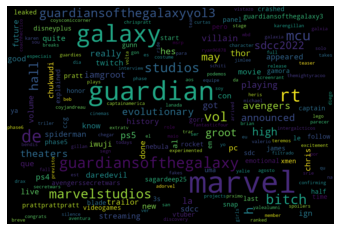

In [36]:
# most common tweet content keywords for brand'guardian'
b = 'guardians'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

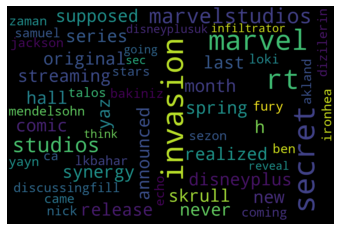

In [38]:
# most common tweet content keywords for brand'secret invasion'
b = 'secret invasion'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

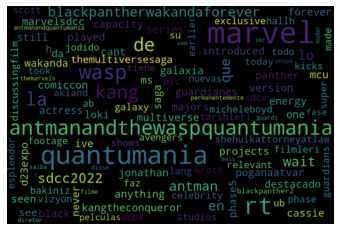

In [39]:
# most common tweet content keywords for brand'quantumania'
b = 'quantumania'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

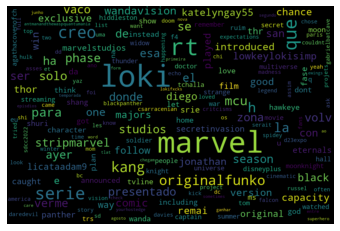

In [40]:
# most common tweet content keywords for brand'loki'
b = 'loki'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

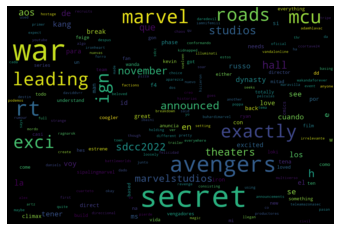

In [41]:
# most common tweet content keywords for brand'secret wars'
b = 'secret wars'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

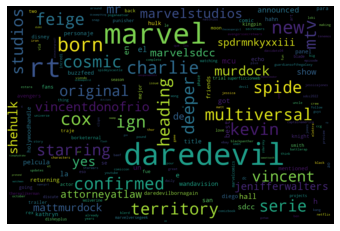

In [42]:
# most common tweet content keywords for brand'daredevil'
b = 'daredevil'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

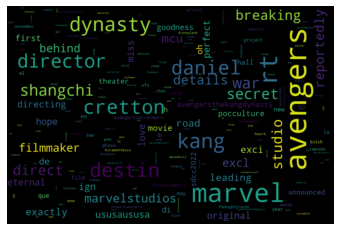

In [43]:
# most common tweet content keywords for brand'avengers'
b = 'avengers'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()